In [1]:
from fpl_helpers import *
import pandas as pd

In [2]:
elements_df, teams_df = get_tables()
global PLAYER_IDS
PLAYER_IDS = elements_df[['full_name', 'id']].set_index('full_name').to_dict()['id']


In [3]:
forwards = elements_df[(elements_df['minutes']>0) & (elements_df['element_type']==4)].sort_values(by='total_points', ascending=False)[PLAYER_COLS].head(20)
forwards['difficulty'] = forwards['full_name'].apply(lambda x: np.mean(difficulty_range(PLAYER_IDS[x], gwrange=1)))
forwards[:20].sort_values(by='difficulty')

,full_name,team,selected_by_percent,now_cost,value_season,total_points,expected_goals,goals_scored,expected_assists,assists,expected_goals_conceded,goals_conceded,difficulty
397,Carlton Morris,Luton,1.7,55,2.7,15,1.36,1,0.37,1,7.25,9,2.166667
524,Callum Wilson,Newcastle,5.1,78,1.7,13,1.46,2,0.00,0,1.42,4,2.333333
356,Darwin Núñez Ribeiro,Liverpool,11.8,74,2.8,21,1.70,2,0.12,2,1.49,0,2.333333
57,Ollie Watkins,Aston Villa,20.8,80,2.1,17,1.36,0,0.18,3,6.82,9,2.333333
506,Alexander Isak,Newcastle,27.1,77,2.5,19,1.40,2,0.09,0,4.03,5,2.333333
237,Nicolas Jackson,Chelsea,18.3,72,1.4,10,2.95,1,0.64,0,4.15,5,2.666667
86,Antoine Semenyo,Bournemouth,3.3,45,2.9,13,0.61,1,0.13,1,6.42,6,2.666667
89,Dominic Solanke,Bournemouth,2.5,65,3.2,21,1.76,2,0.21,1,9.50,8,2.666667
184,Lyle Foster,Burnley,0.8,50,3.0,15,0.81,2,0.09,0,6.85,11,2.833333
129,Yoane Wissa,Brentford,15.4,62,3.9,24,2.46,2,0.08,1,4.20,5,2.833333


In [4]:
compare_players(forwards[4:20]['full_name'], metrics=ATTACKER_METRICS, agg='mean')

,Yoane Wissa,Odsonne Edouard,Darwin Núñez Ribeiro,Dominic Solanke,Eddie Nketiah,Michail Antonio,Alexander Isak,Ollie Watkins,Carlton Morris,Lyle Foster,Callum Wilson,Antoine Semenyo,Cameron Archer,Matheus Santos Carneiro Da Cunha,Chris Wood,Nicolas Jackson
Total Points,5.00,5.70,6.70,4.70,4.00,6.00,2.00,4.00,5.00,5.00,2.70,3.00,4.00,3.30,3.00,3.00
Goals Scored,0.30,0.70,0.70,0.30,0.30,0.70,0.00,0.00,0.30,0.70,0.30,0.30,0.30,0.30,0.30,0.30
Expected Goals,0.70,0.50,0.60,0.30,0.40,0.30,0.20,0.40,0.50,0.30,0.20,0.20,0.10,0.50,0.00,0.80
Assists,0.30,0.00,0.70,0.30,0.30,0.00,0.00,0.70,0.30,0.00,0.00,0.00,0.30,0.00,0.00,0.00
Expected Assists,0.00,0.00,0.00,0.00,0.10,0.10,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.10,0.00,0.20
Expected Goal Involvements,0.80,0.50,0.60,0.30,0.50,0.40,0.20,0.40,0.60,0.30,0.20,0.20,0.10,0.60,0.10,1.00
Bonus,0.70,1.00,1.00,0.30,0.00,1.30,0.00,0.00,0.70,0.30,0.30,0.30,1.00,0.00,0.70,0.30
Bps,12.30,18.30,23.70,12.00,12.70,21.30,6.30,7.00,18.30,17.70,10.00,8.30,10.30,14.00,12.00,12.30
Influence,11.50,25.40,26.30,20.90,12.30,25.70,1.90,9.30,21.10,27.30,12.10,13.90,10.00,19.80,13.10,19.90
Creativity,1.90,5.70,4.50,14.90,20.70,6.90,4.80,23.00,10.20,9.30,3.90,6.10,1.70,15.30,7.10,18.80


In [5]:
sterling = fetch_player_data(PLAYER_IDS["Raheem Sterling"])
salah = fetch_player_data(PLAYER_IDS["Mohamed Salah"])
son = fetch_player_data(PLAYER_IDS["Son Heung-min"])

In [6]:
pd.Series(data=[i['total_points'] for i in sterling['history_past']], index=[i['season_name'] for i in sterling['history_past']], name='Raheem Sterling')

2011/12      3
2012/13     82
2013/14    132
2014/15    158
2015/16     96
2016/17    149
2017/18    229
2018/19    234
2019/20    204
2020/21    154
2021/22    163
2022/23    101
Name: Raheem Sterling, dtype: int64

<Axes: title={'left': 'Total FPL points development for Sterling, Salah and Son'}, xlabel='Season', ylabel='Total FPL points'>

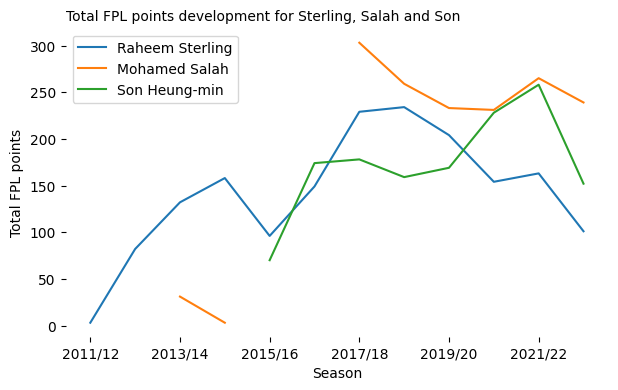

In [7]:

sterling_points = pd.Series(data=[i['total_points'] for i in sterling['history_past']], index=[i['season_name'] for i in sterling['history_past']], name='Raheem Sterling')
salah_points = pd.Series([i['total_points'] for i in salah['history_past']], index=[i['season_name'] for i in salah['history_past']], name='Mohamed Salah')
son_points = pd.Series([i['total_points'] for i in son['history_past']], index=[i['season_name'] for i in son['history_past']], name='Son Heung-min')

df = pd.concat([sterling_points, salah_points, son_points], axis=1)
ax = df.plot(figsize=(7,4))
format_chart(ax, ylabel='Total FPL points', xlabel='Season', title="Total FPL points development for Sterling, Salah and Son")

In [8]:
def get_season_df(season):
    def get_diff_difference(home_or_away, home_diff, away_diff):
        if home_or_away:
            return away_diff - home_diff
        else:
            return home_diff - away_diff
    gamedata = pd.read_csv(f'Fantasy-Premier-League/data/{season}/gws/' + 'merged_gw.csv')
    teams = pd.read_csv(f'Fantasy-Premier-League/data/{season}/' + 'teams.csv')
    fixtures = pd.read_csv(f'Fantasy-Premier-League/data/{season}/' + 'fixtures.csv')
    fixtures['team_h_name'] = fixtures['team_h'].apply(lambda x: teams.set_index('id').name[x])
    fixtures['team_a_name'] = fixtures['team_a'].apply(lambda x: teams.set_index('id').name[x])
    fixtures = fixtures[['id', 'team_a_name', 'team_h_name', 'team_a_difficulty', 'team_h_difficulty']]
    alldata = gamedata.merge(fixtures, left_on='fixture', right_on='id')
    alldata['difficulty_difference'] = alldata.apply(lambda x: get_diff_difference(x['was_home'], x['team_h_difficulty'], x['team_a_difficulty'] ), axis=1)
    return alldata
mydata = get_season_df('2022-23')

In [9]:
# Base path for the CSV files
dataframes = [] 
for i in ['2020-21', '2021-22', '2022-23']:
    dataframes.append(get_season_df(i))
data = pd.concat(dataframes, keys=['2020-21', '2021-22', '2022-23'])
data = data.reset_index(level=0).rename(columns={'level_0': 'Season'})



In [10]:
data = data[data['minutes']>0]

In [11]:
big_hauls = data[data['total_points']>14]
non_hauls = data[data['total_points']<15]

In [12]:
big_hauls.describe()
non_hauls.describe()

,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,GW,id,team_a_difficulty,team_h_difficulty,difficulty_difference,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,...,249.000000,249.000000,249.000000,249.000000,249.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,8.179116,0.598394,2.899598,53.847390,0.574297,22.148594,257.843373,179.084337,0.658635,1.706827,...,18.859438,179.084337,3.188755,2.779116,0.859438,0.103932,0.424843,0.323749,0.559926,0.581081
std,3.825936,0.832407,0.314245,13.934206,0.495445,18.026772,156.299223,116.888823,0.967171,0.797168,...,11.729148,116.888823,1.051360,0.899936,1.270129,0.172596,0.484638,0.396776,0.714329,0.496750
min,0.000000,0.000000,1.000000,31.000000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,...,1.000000,2.000000,2.000000,2.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.600000,0.000000,3.000000,44.000000,0.000000,6.300000,135.000000,73.000000,0.000000,1.000000,...,8.000000,73.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.600000,0.000000,3.000000,51.000000,1.000000,20.100000,255.000000,179.000000,0.000000,2.000000,...,19.000000,179.000000,3.000000,2.000000,1.000000,0.015000,0.305000,0.185000,0.350000,1.000000
75%,10.000000,1.000000,3.000000,61.000000,1.000000,34.200000,360.000000,291.000000,1.000000,2.000000,...,30.000000,291.000000,4.000000,4.000000,2.000000,0.181737,0.714618,0.545000,0.839825,1.000000
max,20.700000,4.000000,3.000000,128.000000,1.000000,75.600000,701.000000,380.000000,6.000000,4.000000,...,38.000000,380.000000,5.000000,5.000000,3.000000,1.007440,1.759650,1.519100,3.260000,1.000000


,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,GW,id,team_a_difficulty,team_h_difficulty,difficulty_difference,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts
count,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,...,31974.000000,31974.000000,31974.000000,31974.000000,31974.000000,11271.000000,11271.000000,11271.00000,11271.000000,11271.000000
mean,2.753128,0.081691,0.206793,12.441140,0.221211,9.810224,301.420904,190.862357,1.088541,0.082442,...,20.066085,190.862357,2.998342,2.745887,-0.011071,0.038276,0.094188,0.06278,0.704822,0.472451
std,2.451736,0.293628,0.654079,9.880946,0.415069,13.388917,180.817872,109.720791,1.206229,0.289123,...,11.017598,109.720791,0.965565,0.883838,1.356993,0.097498,0.210226,0.17473,0.866991,0.499263
min,-3.000000,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,2.000000,2.000000,-3.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,4.000000,0.000000,0.500000,146.000000,96.000000,0.000000,0.000000,...,11.000000,96.000000,2.000000,2.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2.200000,0.000000,0.000000,11.000000,0.000000,3.000000,292.000000,191.000000,1.000000,0.000000,...,21.000000,191.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.347100,0.000000
75%,3.900000,0.000000,0.000000,18.000000,0.000000,14.700000,445.000000,286.000000,2.000000,0.000000,...,29.000000,286.000000,4.000000,3.000000,1.000000,0.025660,0.081440,0.03445,1.240000,1.000000
max,23.600000,3.000000,3.000000,70.000000,1.000000,136.200000,778.000000,380.000000,9.000000,2.000000,...,38.000000,380.000000,5.000000,5.000000,3.000000,1.285270,2.380000,2.37000,5.130000,1.000000


In [13]:
#data = data.reset_index().head().rename(columns={'level_0':"Season"})
data

,Season,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,...,team_a_name,team_h_name,team_a_difficulty,team_h_difficulty,difficulty_difference,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,starts
0,2020-21,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,...,Chelsea,Brighton,3,4,-1,NaN,NaN,NaN,NaN,NaN
2,2020-21,Adam Lallana,MID,Brighton,1.2,0,0,6,0,27.2,...,Chelsea,Brighton,3,4,-1,NaN,NaN,NaN,NaN,NaN
3,2020-21,Adam Webster,DEF,Brighton,0.6,0,0,14,0,11.8,...,Chelsea,Brighton,3,4,-1,NaN,NaN,NaN,NaN,NaN
5,2020-21,Alireza Jahanbakhsh,MID,Brighton,0.8,0,0,3,0,0.7,...,Chelsea,Brighton,3,4,-1,NaN,NaN,NaN,NaN,NaN
6,2020-21,Andreas Christensen,DEF,Chelsea,3.1,0,0,14,0,0.7,...,Chelsea,Brighton,3,4,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26488,2022-23,Boubacar Kamara,MID,Aston Villa,1.2,0,0,14,0,0.0,...,Brighton,Aston Villa,2,3,-1,0.03,0.03,0.00,1.49,1.0
26491,2022-23,Jan Paul van Hecke,DEF,Brighton,0.2,0,0,3,0,0.0,...,Brighton,Aston Villa,2,3,1,0.01,0.01,0.00,0.52,0.0
26493,2022-23,Leon Bailey,MID,Aston Villa,2.0,0,0,13,0,0.0,...,Brighton,Aston Villa,2,3,-1,0.67,0.81,0.14,1.47,1.0
26498,2022-23,Deniz Undav,FWD,Brighton,4.2,0,0,23,0,0.0,...,Brighton,Aston Villa,2,3,1,0.16,1.07,0.91,2.59,1.0


In [14]:
reduced = data[['name', 'total_points', 'GW', "Season"]]
reduced
#reduced[reduced['total_points']>15].set_index('name')['total_points'].sort_values().plot.barh(figsize=(5,10))

,name,total_points,GW,Season
0,Aaron Connolly,1,1,2020-21
2,Adam Lallana,1,1,2020-21
3,Adam Webster,1,1,2020-21
5,Alireza Jahanbakhsh,1,1,2020-21
6,Andreas Christensen,2,1,2020-21
...,...,...,...,...
26488,Boubacar Kamara,2,38,2022-23
26491,Jan Paul van Hecke,1,38,2022-23
26493,Leon Bailey,2,38,2022-23
26498,Deniz Undav,5,38,2022-23


[Text(6, 0, '10'),
 Text(6, 0, '6'),
 Text(6, 0, '5'),
 Text(6, 0, '5'),
 Text(6, 0, '4'),
 Text(6, 0, '4'),
 Text(6, 0, '4'),
 Text(6, 0, '4'),
 Text(6, 0, '4'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3'),
 Text(6, 0, '3')]

<Axes: title={'left': 'Big hauls (>15) last three seasons'}>

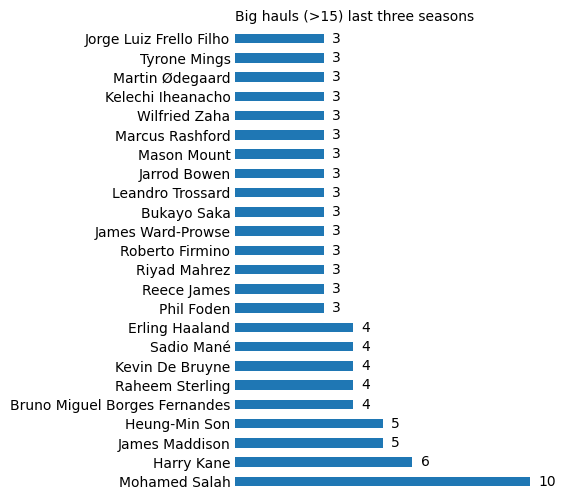

In [15]:
big_hauls = reduced[(reduced['total_points']>14)].set_index(['name', 'Season', 'GW']).sort_index()
big_hauls = big_hauls.reset_index()['name'].value_counts(ascending=False)
ax = big_hauls[big_hauls>2].plot.barh(figsize=(4,6))
ax = format_chart(ax, title="Big hauls (>15) last three seasons")
ax.bar_label(ax.containers[0], padding=6)
ax.tick_params(axis='y', length=0)
ax.get_xaxis().set_visible(False)
ax

['Erling Haaland',
 'Martin Ødegaard',
 'Leandro Trossard',
 'Harry Kane',
 'Eberechi Eze',
 'Mohamed Salah',
 'Bukayo Saka',
 'Marcus Rashford',
 'Raheem Sterling']

[Text(6, 0, '4'),
 Text(6, 0, '3'),
 Text(6, 0, '2'),
 Text(6, 0, '2'),
 Text(6, 0, '2'),
 Text(6, 0, '2'),
 Text(6, 0, '2'),
 Text(6, 0, '2'),
 Text(6, 0, '2')]

<Axes: title={'left': 'Big hauls (>15) last season'}>

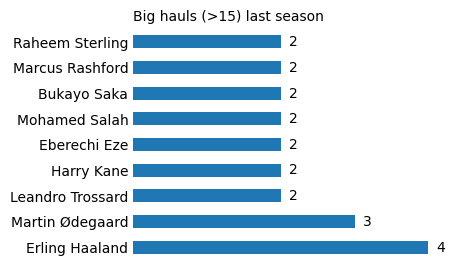

In [16]:
big_hauls = reduced[(reduced['total_points']>14) & (reduced['Season']=='2022-23')].set_index(['name', 'Season', 'GW']).sort_index()
big_hauls = big_hauls.reset_index()['name'].value_counts(ascending=False)
big_haul_players = list(big_hauls[big_hauls>1].index)
big_haul_players
ax = big_hauls[big_hauls>1].plot.barh(figsize=(4,3))
ax = format_chart(ax, title="Big hauls (>15) last season")
ax.bar_label(ax.containers[0], padding=6)
ax.tick_params(axis='y', length=0)
ax.get_xaxis().set_visible(False)
ax

In [17]:
def fetch_player_data(player_id):
    playerurl = f'https://fantasy.premierleague.com/api/element-summary/{player_id}/'
    r = requests.get(playerurl)
    json = r.json()
    return json
saka = fetch_player_data(PLAYER_IDS['Bukayo Saka'])

In [18]:
#big_haul_players.append("Bryan Mbeumo")
compare_players(big_haul_players, metrics=ATTACKER_METRICS, agg='mean', start_gameweek=0, gameweeks=3)

,Erling Haaland,Martin Ødegaard,Leandro Trossard,Harry Kane,Eberechi Eze,Mohamed Salah,Bukayo Saka,Marcus Rashford,Raheem Sterling
Total Points,6.30,5.00,0.70,0.00,2.30,5.00,7.00,4.00,7.70
Goals Scored,1.00,0.30,0.00,0.00,0.00,0.30,0.70,0.00,0.70
Expected Goals,1.00,0.40,0.00,0.00,0.40,0.60,0.60,0.30,0.30
Assists,0.00,0.00,0.00,0.00,0.00,0.70,0.00,0.70,0.30
Expected Assists,0.00,0.10,0.20,0.00,0.30,0.20,0.50,0.20,0.20
Expected Goal Involvements,1.00,0.50,0.20,0.00,0.60,0.70,1.00,0.50,0.50
Bonus,1.00,1.00,0.00,0.00,0.00,0.00,1.30,0.00,1.00
Bps,23.70,17.70,6.00,0.00,14.00,16.30,26.00,7.30,24.30
Influence,35.00,22.80,4.90,0.00,13.20,28.90,38.50,12.30,33.50
Creativity,16.10,18.50,18.20,0.00,46.60,26.00,46.60,17.90,27.60


In [19]:
from fpl_helpers import *
elements_df, teams_df = get_tables()
global PLAYER_IDS

PLAYER_IDS = elements_df[['full_name', 'id']].set_index('full_name').to_dict()['id']
player_past_metrics(PLAYER_IDS['Erling Haaland'], metrics=ATTACKER_METRICS, gameweeks=3, start_gameweek=0)

{'total_points': [13, 2, 4],
 'goals_scored': [2, 0, 1],
 'expected_goals': ['0.60', '0.43', '1.93'],
 'assists': [0, 0, 0],
 'expected_assists': ['0.05', '0.02', '0.01'],
 'expected_goal_involvements': ['0.65', '0.45', '1.94'],
 'bonus': [3, 0, 0],
 'bps': [56, 1, 14],
 'influence': ['67.6', '3.2', '34.2'],
 'creativity': ['23.7', '11.8', '12.9'],
 'threat': ['48.0', '48.0', '97.0'],
 'ict_index': ['13.9', '6.3', '14.4'],
 'starts': [1, 1, 1]}

In [20]:
data[['fixture', 'element']]

,fixture,element
0,7,78
2,7,54
3,7,66
5,7,71
6,7,116
...,...,...
26488,372,53
26491,372,544
26493,372,45
26498,372,123


In [21]:
def get_team(team_id, gw):
  url = f"https://fantasy.premierleague.com/api/entry/{team_id}/event/{gw}/picks/"
  r = requests.get(url)
  json = r.json()
  return json

player_ids = [str(i['element']) for i in get_team(3053203, 4)['picks']]

In [22]:
player_ids

['524',
 '341',
 '36',
 '131',
 '504',
 '599',
 '19',
 '308',
 '108',
 '355',
 '523',
 '275',
 '13',
 '405',
 '602']

In [23]:
player_names = {v: k for k, v in PLAYER_IDS.items()}
compare_players([player_names[int(i)] for i in player_ids[0:4]] + ["Sven Botman"] , metrics=DEFENDER_METRICS, agg='mean')
compare_players([player_names[int(i)] for i in player_ids[4:9]], metrics=ATTACKER_METRICS, agg='mean')
compare_players([player_names[int(i)] for i in player_ids[9:13]], metrics=ATTACKER_METRICS, agg='mean')

,Alphonse Areola,Manuel Akanji,Matty Cash,Pervis Estupiñán,Sven Botman
Minutes,90.00,60.00,90.00,90.00,58.70
Clean Sheets,0.00,0.30,0.30,0.00,0.00
Goals Conceded,1.00,0.30,1.30,1.70,0.70
Own Goals,0.00,0.00,0.30,0.00,0.00
Yellow Cards,0.00,0.00,0.00,0.30,0.00
Red Cards,0.00,0.00,0.00,0.00,0.00
Bonus,0.70,0.30,1.00,0.30,0.00
Bps,22.00,15.30,24.00,20.30,10.00
Influence,32.70,10.60,37.90,27.90,7.70
Creativity,0.00,7.50,6.90,27.30,0.60


,James Maddison,Moussa Diaby,Bukayo Saka,Mohamed Salah,Bryan Mbeumo
Total Points,6.70,5.70,5.00,6.00,8.70
Goals Scored,0.70,0.30,0.30,0.70,1.00
Expected Goals,0.50,0.20,0.70,0.70,0.90
Assists,0.00,0.30,0.30,0.30,0.00
Expected Assists,0.30,0.10,0.50,0.10,0.30
Expected Goal Involvements,0.80,0.30,1.10,0.80,1.20
Bonus,0.70,0.70,0.30,0.00,1.30
Bps,26.00,18.30,21.00,20.00,25.00
Influence,37.70,22.30,32.20,38.40,43.50
Creativity,28.50,22.30,53.90,27.00,34.20


,Erling Haaland,Michail Antonio,Bernd Leno,Eddie Nketiah
Total Points,8.70,6.00,2.30,4.00
Goals Scored,1.30,0.70,0.00,0.30
Expected Goals,1.30,0.30,0.00,0.40
Assists,0.30,0.00,0.00,0.30
Expected Assists,0.00,0.10,0.00,0.10
Expected Goal Involvements,1.40,0.40,0.00,0.50
Bonus,1.00,1.30,0.70,0.00
Bps,35.00,21.30,18.70,12.70
Influence,52.30,25.70,35.50,12.30
Creativity,16.00,6.90,0.00,20.70


In [24]:
player_names[int(player_ids[0])]
difficulty_range(player_ids[0], end_gameweek=6, gwrange=1)

'Alphonse Areola'

[5.0, 4.0, 2.0, 4.0, 3.0, 2.0]

In [25]:
compare_players(['Nicolas Jackson', 'Odsonne Edouard'], metrics=ATTACKER_METRICS, agg='mean')

,Nicolas Jackson,Odsonne Edouard
Total Points,3.00,5.70
Goals Scored,0.30,0.70
Expected Goals,0.80,0.50
Assists,0.00,0.00
Expected Assists,0.20,0.00
Expected Goal Involvements,1.00,0.50
Bonus,0.30,1.00
Bps,12.30,18.30
Influence,19.90,25.40
Creativity,18.80,5.70


In [26]:
difficulty_range(PLAYER_IDS['Michail Antonio'], gwrange=1)
difficulty_range(PLAYER_IDS['Nicolas Jackson'], gwrange=1)
difficulty_range(PLAYER_IDS['Odsonne Edouard'], gwrange=1)

[5.0, 4.0, 2.0, 4.0, 3.0, 2.0]

[2.0, 3.0, 2.0, 2.0, 4.0, 3.0]

[3.0, 2.0, 4.0, 2.0, 4.0, 3.0]

In [27]:
list(PLAYER_IDS.keys())

['Folarin Balogun',
 'Cédric Alves Soares',
 'Mohamed Elneny',
 'Fábio Ferreira Vieira',
 'Gabriel dos Santos Magalhães',
 'Kai Havertz',
 'Gabriel Fernando de Jesus',
 'Jorge Luiz Frello Filho',
 'Jakub Kiwior',
 'Marcus Oliveira Alencar',
 'Gabriel Martinelli Silva',
 'Eddie Nketiah',
 'Martin Ødegaard',
 'Thomas Partey',
 'Nicolas Pépé',
 'Aaron Ramsdale',
 'Rúnar Alex Rúnarsson',
 'Bukayo Saka',
 'William Saliba',
 'Emile Smith Rowe',
 'Kieran Tierney',
 'Takehiro Tomiyasu',
 'Leandro Trossard',
 'Benjamin White',
 'Granit Xhaka',
 'Oleksandr Zinchenko',
 'David Raya Martin',
 'Declan Rice',
 'Reiss Nelson',
 'Jurriën Timber',
 'Karl Hein',
 'Alexandre Moreno Lopera',
 'Leon Bailey',
 'Emiliano Buendía Stati',
 'Matty Cash',
 'Calum Chambers',
 'Philippe Coutinho Correia',
 'Keinan Davis',
 'Leander Dendoncker',
 'Diego Carlos Santos Silva',
 'Lucas Digne',
 'Douglas Luiz Soares de Paulo',
 'Jhon Durán',
 'Kortney Hause',
 'Tim Iroegbunam',
 'Boubacar Kamara',
 'Ezri Konsa Ngoyo',


<Axes: title={'left': 'Defence at home'}>

<Axes: title={'left': 'Attack away'}>

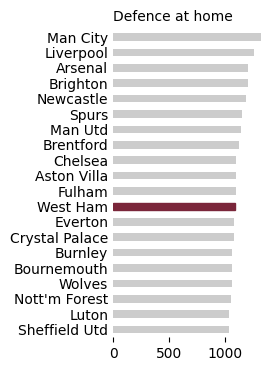

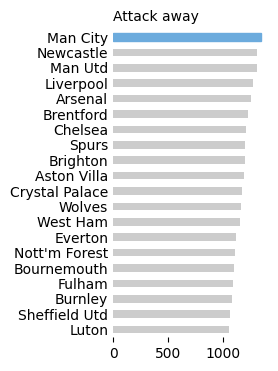

In [28]:
compare_team(teams_df, 'strength_defence_home', "West Ham", title="Defence at home")
compare_team(teams_df, 'strength_attack_away', "Manchester City", short_team_name="Man City", title="Attack away")

<Axes: title={'left': 'Defence at home'}>

<Axes: title={'left': 'Attack away'}>

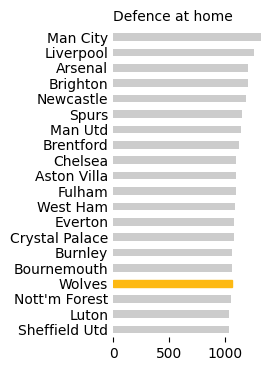

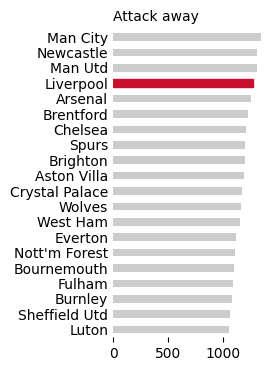

In [29]:
compare_team(teams_df, 'strength_defence_home', "Wolves", title="Defence at home")
compare_team(teams_df, 'strength_attack_away', "Liverpool", title="Attack away")